<a href="https://colab.research.google.com/github/BlackBoyZeus/CfC/blob/main/ltc_example_sinusoidal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The basics of Neural Circuit Policies

In this tutorial we will build three recurrent neural networks based on the LTC model:

*   A fully-connected network
*   A sparse, randomly wired network
*   A sparse, structured network based on the NCP principles

![wirings.png](https://raw.githubusercontent.com/mlech26l/keras-ncp/master/misc/wirings.png)

We will train these networks on some generated time-series and compare their training performance.

In [1]:
# Install dependencies if they are not installed yet
!pip install seaborn ncps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 9.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import os
from tensorflow import keras
from ncps import wirings
from ncps.tf import LTC
import matplotlib.pyplot as plt
import seaborn as sns

## Generating synthetic sinusoidal training data

data_x.shape:  (1, 48, 2)
data_y.shape:  (1, 48, 1)


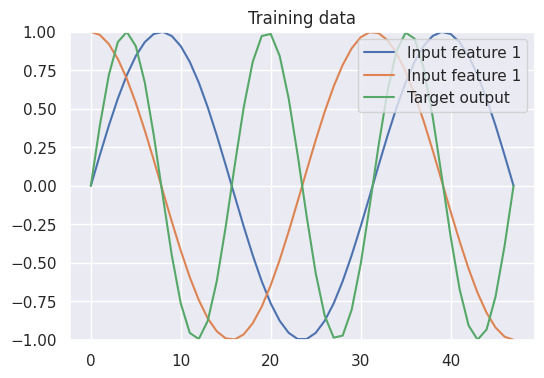

In [3]:
N = 48 # Length of the time-series
# Input feature is a sine and a cosine wave
data_x = np.stack(
    [np.sin(np.linspace(0, 3 * np.pi, N)), np.cos(np.linspace(0, 3 * np.pi, N))], axis=1
)
data_x = np.expand_dims(data_x, axis=0).astype(np.float32)  # Add batch dimension
# Target output is a sine with double the frequency of the input signal
data_y = np.sin(np.linspace(0, 6 * np.pi, N)).reshape([1, N, 1]).astype(np.float32)
print("data_x.shape: ", str(data_x.shape))
print("data_y.shape: ", str(data_y.shape))

# Let's visualize the training data
sns.set()
plt.figure(figsize=(6, 4))
plt.plot(data_x[0, :, 0], label="Input feature 1")
plt.plot(data_x[0, :, 1], label="Input feature 1")
plt.plot(data_y[0, :, 0], label="Target output")
plt.ylim((-1, 1))
plt.title("Training data")
plt.legend(loc="upper right")
plt.show()

## The LTC model

The ```ncps``` package is composed of two main parts:

- The LTC model as a ```tf.keras.layers.Layer``` RNN
- An wiring architecture for the LTC cell above

The wiring could be fully-connected (all-to-all) or sparsely designed using the NCP principles introduced in the paper.

Note that as the LTC model is expressed in the form of a system of [ordinary differential equations in time](https://arxiv.org/abs/2006.04439), any instance of it is inherently a recurrent neural network (RNN).
That's why this simple example considers a sinusoidal time-series.



### Our first LTC model with fully-connected wiring

In [4]:
fc_wiring = wirings.FullyConnected(8, 1)  # 8 units, 1 of which is a motor neuron

model = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=(None, 2)),
        LTC(fc_wiring, return_sequences=True),
    ]
)
model.compile(
    optimizer=keras.optimizers.Adam(0.01), loss='mean_squared_error'
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ltc (LTC)                   (None, None, 1)           350       
                                                                 
Total params: 350 (1.37 KB)
Trainable params: 350 (1.37 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Draw the wiring diagram of the network

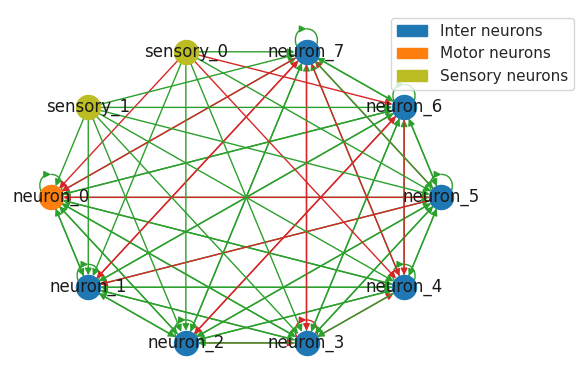

In [5]:
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = fc_wiring.draw_graph(draw_labels=True)
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

### Visualizing the prediction of the network before training

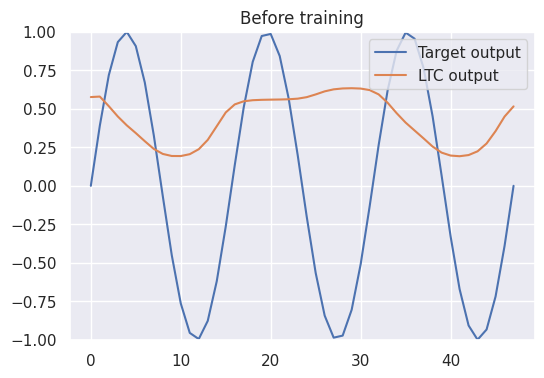

In [6]:
# Let's visualize how LTC initialy performs before the training
sns.set()
prediction = model(data_x).numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="LTC output")
plt.ylim((-1, 1))
plt.title("Before training")
plt.legend(loc="upper right")
plt.show()

### Training the model

In [7]:
# Train the model for 400 epochs (= training steps)
hist = model.fit(x=data_x, y=data_y, batch_size=1, epochs=400,verbose=1)

Epoch 1/400
1/1 [==============================] - 4s 4s/step - loss: 0.6508
Epoch 2/400
1/1 [==============================] - 0s 59ms/step - loss: 0.5789
Epoch 3/400
1/1 [==============================] - 0s 38ms/step - loss: 0.5251
Epoch 4/400
1/1 [==============================] - 0s 39ms/step - loss: 0.4932
Epoch 5/400
1/1 [==============================] - 0s 40ms/step - loss: 0.4804
Epoch 6/400
1/1 [==============================] - 0s 37ms/step - loss: 0.4800
Epoch 7/400
1/1 [==============================] - 0s 36ms/step - loss: 0.4848
Epoch 8/400
1/1 [==============================] - 0s 37ms/step - loss: 0.4876
Epoch 9/400
1/1 [==============================] - 0s 38ms/step - loss: 0.4855
Epoch 10/400
1/1 [==============================] - 0s 36ms/step - loss: 0.4789
Epoch 11/400
1/1 [==============================] - 0s 35ms/step - loss: 0.4696
Epoch 12/400
1/1 [==============================] - 0s 37ms/step - loss: 0.4599
Epoch 13/400
1/1 [==============================] -

### Plotting the training loss

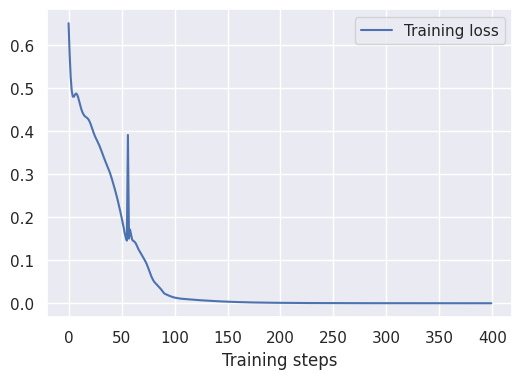

In [8]:
# Let's visualize the training loss
sns.set()
plt.figure(figsize=(6, 4))
plt.plot(hist.history["loss"], label="Training loss")
plt.legend(loc="upper right")
plt.xlabel("Training steps")
plt.show()

### Plotting the prediction of the trained model

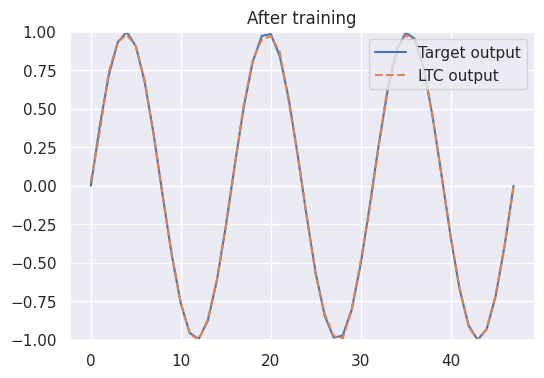

In [9]:
# How does the trained model now fit to the sinusoidal function?
prediction = model(data_x).numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="LTC output",linestyle="dashed")
plt.ylim((-1, 1))
plt.legend(loc="upper right")
plt.title("After training")
plt.show()

## Other wiring architectures

Next, let's see how we can define other wiring architectures and compare them to the fully-connected network above



### Random network with 75% sparsity

Let's create a randomly wired network where 75% of all synapses are removed.

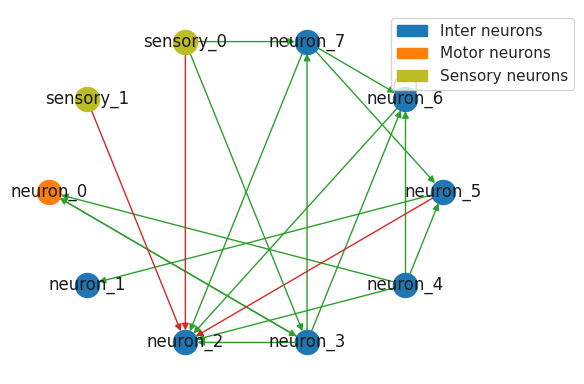

In [10]:
# Define LTC cell and wiring architecture
rnd_wiring = wirings.Random(8, 1,sparsity_level=0.75)  # 8 units, 1 motor neuron

# Define Keras model
sparse_model = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=(None, 2)),
        LTC(rnd_wiring, return_sequences=True),
    ]
)
sparse_model.compile(
    optimizer=keras.optimizers.Adam(0.01), loss='mean_squared_error'
)

# Plot the wiring
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = rnd_wiring.draw_graph(draw_labels=True)
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

### Comparing random sparse vs fully-connected networks

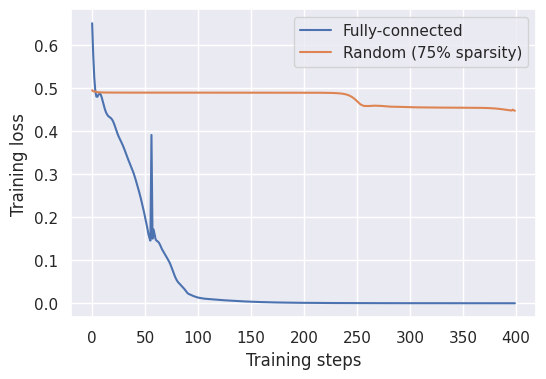

In [11]:
hist_rand = sparse_model.fit(x=data_x, y=data_y, batch_size=1, epochs=400,verbose=0)
# This may take a while (training the sprase LTC model)
sns.set()
plt.figure(figsize=(6, 4))
plt.plot(hist.history["loss"], label="Fully-connected")
plt.plot(hist_rand.history["loss"], label="Random (75% sparsity)")
plt.legend(loc="upper right")
plt.xlabel("Training steps")
plt.ylabel("Training loss")
plt.show()

We see that the sparse model is not able to fit the sinusoidal signal as perfectly as the fully-connected architecture.

### Neural Circuit Policy wiring architecture

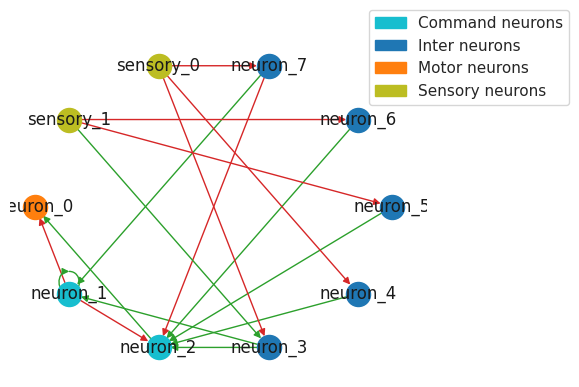

In [12]:
ncp_arch = wirings.AutoNCP(8,1)

ncp_model = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=(None, 2)),
        LTC(ncp_arch, return_sequences=True),
    ]
)
ncp_model.compile(
    optimizer=keras.optimizers.Adam(0.01), loss='mean_squared_error'
)
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = ncp_arch.draw_graph(draw_labels=True, neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1.1, 1.1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

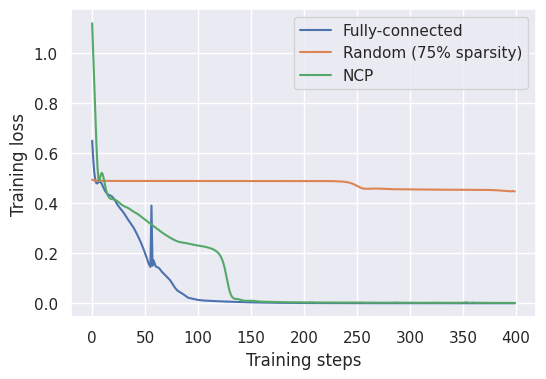

In [13]:
hist_ncp = ncp_model.fit(x=data_x, y=data_y, batch_size=1, epochs=400,verbose=0)
# This may take a while (training the LTC model)
sns.set()
plt.figure(figsize=(6, 4))
plt.plot(hist.history["loss"], label="Fully-connected")
plt.plot(hist_rand.history["loss"], label="Random (75% sparsity)")
plt.plot(hist_ncp.history["loss"], label="NCP")
plt.legend(loc="upper right")
plt.xlabel("Training steps")
plt.ylabel("Training loss")
plt.show()

We see that the network with the NCP wiring architecture could fit the data as close as the fully-connected model.

### Computing the sparsity of a NCP network




In [14]:
# Let's compare how many synapses the NCP network has compared to the fully-connected one
sparsity = 1 - ncp_arch.synapse_count /fc_wiring.synapse_count
print("Sparsity level is {:0.2f}%".format(100*sparsity))

Sparsity level is 82.81%


The network with the NCP wiring performs as good as the fully-connected network but is even sparser than our random network tested above.